In [1]:
import numpy as np
import pandas as pd
import gc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
import pickle
import shap
import matplotlib.pyplot as plt
import xgboost

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from functools import partial

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

from bo_parameters import *

In [3]:
lgbm_tuned = {
    "learning_rate" : 0.10284216487315759, 
    "max_depth" : 4, 
    "n_estimators" : 955
}
# lgbm_tuned += LIGHTGBM_PARAMS

xgb_tuned = {
    "learning_rate" : 0.3317433223693123, 
    "max_depth" : 4, 
    "n_estimators" : 772
}
# xgb_tuned += XGBOOST_PARAMS

tabnet_tuned = {
    "gamma" : 1.0131059206061017, 
    "lambda_sparse" : 0.0051151725754103195, 
    "n_steps" : 10,
    "n_a" : 54,
}
tabnet_tuned["n_d"] = tabnet_tuned["n_a"]

tabnet_paper = {
    "gamma" : 1.5, 
    "lambda_sparse" : 0.0001, 
    "n_steps" : 5,
    "n_a" : 16,
    "momentum" : 0.98,
}
tabnet_paper["n_d"] = tabnet_paper["n_a"]

xgb_paper = {
    "base_score" : 0.5,
    "max_depth" : 5, 
    "n_estimators" : 500
}

In [4]:
column_names = ["age", "workclass", "fnlwgt", "education", "education_num", "martial_status", "occupation", "relationship",
               "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "TARGET"]

In [5]:
data = pd.read_csv("data/census_income/train.csv", names=column_names, header=0)

In [6]:
train = pd.read_csv("data/census_income/train.csv", names=column_names, header=0)
valid = pd.read_csv("data/census_income/val.csv", names=column_names, header=0)
test = pd.read_csv("data/census_income/test.csv", names=column_names, header=0)

In [6]:
column_names = {
    0 : "age",
    1 : "workclass",
    2 : "fnlwgt",
    3 : "education",
    4 : "education_num",
    5 : "martial_status",
    6 : "occupation",
    7 : "relationship",
    8 : "race",
    9 : "sex", 
    10 : "capital_gain",
    11 : "capital_loss",
    12 : "hours_per_week",
    13 : "native_country"
}

In [7]:
train.head()

,age,workclass,fnlwgt,education,education_num,martial_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,TARGET
0,34,6,56460,11,9,2,5,5,4,0,0,2179,12,39,0
1,48,6,243631,15,10,2,3,0,0,1,7688,0,40,39,1
2,23,7,56402,15,10,2,10,0,4,1,0,0,30,39,0
3,56,2,255406,11,9,0,4,1,4,0,0,0,40,39,0
4,17,4,297246,1,7,4,9,3,4,0,0,0,9,39,0


In [8]:
categorical_idx = [1, 3, 5, 6, 7 ,8 , 9, 13]
categorical_dims = [len(set(list(train.iloc[:, x].unique()) + list(valid.iloc[:, x].unique()) + list(test.iloc[:, x].unique()))) for x in categorical_idx]

In [9]:
train = pd.concat([train, valid])

In [10]:
train_X = train.drop(["TARGET"], axis=1)
train_y = train["TARGET"]

test_X = test.drop(["TARGET"], axis=1)
test_y = test["TARGET"]

In [9]:
X = data.drop(["TARGET"], axis=1)
y = data["TARGET"]

In [10]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=78)

In [11]:
model_lgbm = LGBMClassifier(**{**lgbm_tuned, **LIGHTGBM_PARAMS})
model_lgbm.fit(train_X, train_y, verbose=1, categorical_feature=categorical_idx)

Using categorical_feature in Dataset.


LGBMClassifier(learning_rate=0.10284216487315759, max_depth=4, metric='auc',
               n_estimators=955, objective='binary', random_state=42)

In [12]:
model_xgb = XGBClassifier(**{**xgb_tuned, **XGBOOST_PARAMS})
model_xgb.fit(train_X, train_y, verbose=1)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[01:43:41] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3317433223693123, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=772, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [13]:
model_xgb_paper = XGBClassifier(**{**xgb_paper, **XGBOOST_PARAMS})
model_xgb_paper.fit(train_X, train_y, verbose=1)

[01:43:56] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:43:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [14]:
TABNET_PARAMS["verbose"] = 1

In [15]:
model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS}, cat_idxs=categorical_idx, cat_dims=categorical_dims)
model_tabnet.fit(train_X.values, train_y.values, max_epochs=60)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.92176 |  0:00:17s
epoch 1  | loss: 0.42582 |  0:00:35s
epoch 2  | loss: 0.38057 |  0:00:53s
epoch 3  | loss: 0.34665 |  0:01:12s
epoch 4  | loss: 0.33823 |  0:01:31s
epoch 5  | loss: 0.33607 |  0:01:49s
epoch 6  | loss: 0.33196 |  0:02:07s
epoch 7  | loss: 0.33481 |  0:02:25s
epoch 8  | loss: 0.33147 |  0:02:42s
epoch 9  | loss: 0.33245 |  0:03:00s
epoch 10 | loss: 0.33212 |  0:03:17s
epoch 11 | loss: 0.33384 |  0:03:34s
epoch 12 | loss: 0.33043 |  0:03:52s
epoch 13 | loss: 0.32611 |  0:04:09s
epoch 14 | loss: 0.32923 |  0:04:26s
epoch 15 | loss: 0.33246 |  0:04:43s
epoch 16 | loss: 0.32817 |  0:05:00s
epoch 17 | loss: 0.33344 |  0:05:16s
epoch 18 | loss: 0.32603 |  0:05:34s
epoch 19 | loss: 0.3291  |  0:05:50s
epoch 20 | loss: 0.32969 |  0:06:09s
epoch 21 | loss: 0.3273  |  0:06:26s
epoch 22 | loss: 0.32244 |  0:06:43s
epoch 23 | loss: 0.32381 |  0:07:03s
epoch 24 | loss: 0.32

In [16]:
model_tabnet_paper = TabNetClassifier(**{**tabnet_paper, **TABNET_PARAMS}, cat_idxs=categorical_idx, cat_dims=categorical_dims)
model_tabnet_paper.fit(train_X.values, train_y.values, max_epochs=60, batch_size=4096)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.80463 |  0:00:03s
epoch 1  | loss: 0.45054 |  0:00:07s
epoch 2  | loss: 0.40788 |  0:00:10s
epoch 3  | loss: 0.39419 |  0:00:13s
epoch 4  | loss: 0.38162 |  0:00:17s
epoch 5  | loss: 0.37134 |  0:00:20s
epoch 6  | loss: 0.36961 |  0:00:24s
epoch 7  | loss: 0.36316 |  0:00:27s
epoch 8  | loss: 0.35604 |  0:00:31s
epoch 9  | loss: 0.35892 |  0:00:34s
epoch 10 | loss: 0.3559  |  0:00:37s
epoch 11 | loss: 0.34944 |  0:00:41s
epoch 12 | loss: 0.34844 |  0:00:45s
epoch 13 | loss: 0.34495 |  0:00:48s
epoch 14 | loss: 0.34338 |  0:00:52s
epoch 15 | loss: 0.34147 |  0:00:55s
epoch 16 | loss: 0.34162 |  0:00:59s
epoch 17 | loss: 0.34165 |  0:01:02s
epoch 18 | loss: 0.33842 |  0:01:05s
epoch 19 | loss: 0.34187 |  0:01:09s
epoch 20 | loss: 0.33774 |  0:01:12s
epoch 21 | loss: 0.33907 |  0:01:16s
epoch 22 | loss: 0.33802 |  0:01:19s
epoch 23 | loss: 0.33535 |  0:01:23s
epoch 24 | loss: 0.33

In [11]:
with open('model_tabnet.pickle', 'wb') as f:
    pickle.dump(model_tabnet, f)
with open('model_tabnet_paper.pickle', 'wb') as f:
    pickle.dump(model_tabnet_paper, f)

In [10]:
with open('model_tabnet.pickle', 'rb') as f:
    model_tabnet = pickle.load(f)
with open('model_tabnet_paper.pickle', 'rb') as f:
    model_tabnet_paper = pickle.load(f)

In [17]:
print("LightGBM auc: ", round(roc_auc_score(test_y, model_lgbm.predict_proba(test_X)[:, 1]), 6))
print("XGBoost auc: ", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X)[:, 1]), 6))
print("XGBoost Paper auc: ", round(roc_auc_score(test_y, model_xgb_paper.predict_proba(test_X)[:, 1]), 6))
print("TabNet auc: ", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X.values)[:, 1]), 6))
print("TabNet Paper auc: ", round(roc_auc_score(test_y, model_tabnet_paper.predict_proba(test_X.values)[:, 1]), 6))

LightGBM auc:  0.921625
XGBoost auc:  0.913813
XGBoost Paper auc:  0.913702
TabNet auc:  0.908718
TabNet Paper auc:  0.901131


In [18]:
print("LightGBM acc: ", round(accuracy_score(test_y, model_lgbm.predict(test_X)), 6))
print("XGBoost acc: ", round(accuracy_score(test_y, model_xgb.predict(test_X)), 6))
print("XGBoost Paper acc: ", round(accuracy_score(test_y, model_xgb_paper.predict(test_X)), 6))
print("TabNet acc: ", round(accuracy_score(test_y, model_tabnet.predict(test_X.values)), 6))
print("TabNet Paper acc: ", round(accuracy_score(test_y, model_tabnet_paper.predict(test_X.values)), 6))

LightGBM acc:  0.870829
XGBoost acc:  0.86346
XGBoost Paper acc:  0.864483
TabNet acc:  0.855271
TabNet Paper acc:  0.850358


In [34]:
model_lgbm.feature_importances_

array([2468,  327, 3060,  497,  969,  232,  911,  220,   78,  206,  970,
        787, 1575,  453], dtype=int32)

In [33]:
model_xgb.feature_importances_

array([0.03652314, 0.02215287, 0.01783302, 0.01717239, 0.12828383,
       0.10453314, 0.03037683, 0.33732754, 0.02034082, 0.03909687,
       0.13433015, 0.06816406, 0.03022396, 0.01364144], dtype=float32)

In [19]:
model_tabnet.feature_importances_

array([0.14039684, 0.03198697, 0.02561015, 0.05409149, 0.12356052,
       0.00399008, 0.12925596, 0.16550778, 0.02876345, 0.04100787,
       0.08514628, 0.0299493 , 0.12511469, 0.01561862])

In [22]:
importance_lgbm = list(enumerate(model_lgbm.feature_importances_))
importance_xgb = model_xgb.get_booster().get_score(importance_type='weight').items()
importance_xgb_paper = model_xgb_paper.get_booster().get_score(importance_type='weight').items()
importance_tabnet = list(enumerate(model_tabnet.feature_importances_))
importance_tabnet_paper = list(enumerate(model_tabnet_paper.feature_importances_))

In [23]:
importance_lgbm = sorted(importance_lgbm, key=lambda x: x[1], reverse=True)
importance_xgb = sorted(importance_xgb, key=lambda x: x[1], reverse=True)
importance_xgb_paper = sorted(importance_xgb_paper, key=lambda x: x[1], reverse=True)
importance_tabnet = sorted(importance_tabnet, key=lambda x: x[1], reverse=True)
importance_tabnet_paper = sorted(importance_tabnet_paper, key=lambda x: x[1], reverse=True)

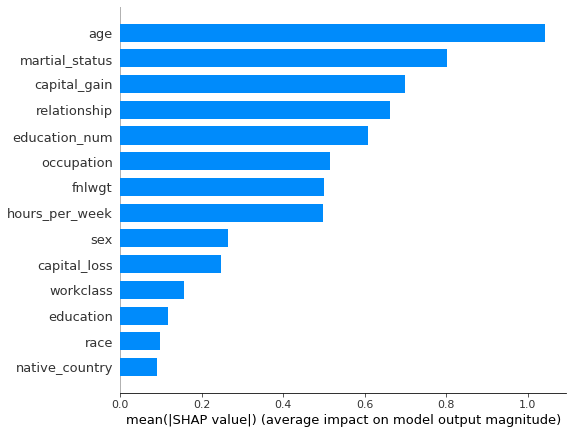

In [24]:
shap_values = shap.TreeExplainer(model_xgb).shap_values(train_X)
shap.summary_plot(shap_values, train_X, plot_type="bar")

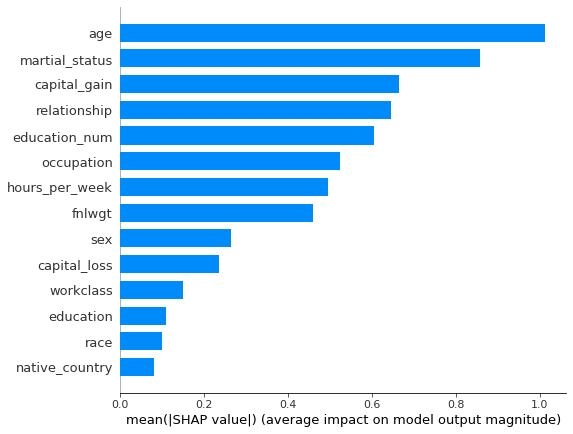

In [25]:
shap_values_paper = shap.TreeExplainer(model_xgb_paper).shap_values(train_X)
shap.summary_plot(shap_values_paper, train_X, plot_type="bar")

In [50]:
train_X.columns[np.argsort(np.abs(shap_values).mean(0))][::-1]

Index(['age', 'martial_status', 'relationship', 'capital_gain',
       'education_num', 'hours_per_week', 'fnlwgt', 'occupation',
       'capital_loss', 'sex', 'workclass', 'education', 'race',
       'native_country'],
      dtype='object')

In [26]:
df_compare = pd.DataFrame([column_names[x[0]] for x in importance_lgbm], columns=["LightGBM"])
df_compare["XGBoost"] = [x[0] for x in importance_xgb]
df_compare["XGBoost_Paper"] = [x[0] for x in importance_xgb_paper]
df_compare["SHAP_XGBoost"] = train_X.columns[np.argsort(np.abs(shap_values).mean(0))][::-1]
df_compare["SHAP_XGBoost_Paper"] = train_X.columns[np.argsort(np.abs(shap_values_paper).mean(0))][::-1]
df_compare["TabNet"] = [column_names[x[0]] for x in importance_tabnet]
df_compare["TabNet_Paper"] = [column_names[x[0]] for x in importance_tabnet_paper]

In [28]:
df_compare

,LightGBM,XGBoost,XGBoost_Paper,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper
0,fnlwgt,fnlwgt,fnlwgt,age,age,relationship,martial_status
1,age,age,age,martial_status,martial_status,age,education_num
2,hours_per_week,hours_per_week,hours_per_week,capital_gain,capital_gain,occupation,capital_gain
3,education_num,occupation,occupation,relationship,relationship,hours_per_week,occupation
4,capital_gain,education_num,education_num,education_num,education_num,education_num,capital_loss
5,occupation,capital_gain,education,occupation,occupation,capital_gain,age
6,capital_loss,education,capital_gain,fnlwgt,hours_per_week,education,relationship
7,education,workclass,workclass,hours_per_week,fnlwgt,sex,hours_per_week
8,native_country,capital_loss,capital_loss,sex,sex,workclass,native_country
9,workclass,native_country,relationship,capital_loss,capital_loss,capital_loss,education


In [56]:
top_3 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:2, col1]) & set(df_compare.loc[:2, col2])))
        top_3.append(d)
top_3_data = pd.DataFrame(top_3, columns=["Model1", "Model2", "Sim"])
    

In [57]:
pd.pivot_table(top_3_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper,XGBoost,XGBoost_Paper
Model1,,,,,,,
LightGBM,3,1,1,1,0,3,3
SHAP_XGBoost,1,3,3,1,2,1,1
SHAP_XGBoost_Paper,1,3,3,1,2,1,1
TabNet,1,1,1,3,0,1,1
TabNet_Paper,0,2,2,0,3,0,0
XGBoost,3,1,1,1,0,3,3
XGBoost_Paper,3,1,1,1,0,3,3


TODO: 3 признака из каждой и обучить бустинги

In [60]:
top_5 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:4, col1]) & set(df_compare.loc[:4, col2])))
        top_5.append(d)
top_5_data = pd.DataFrame(top_5, columns=["Model1", "Model2", "Sim"])
    

In [61]:
pd.pivot_table(top_5_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper,XGBoost,XGBoost_Paper
Model1,,,,,,,
LightGBM,5,3,3,3,2,4,4
SHAP_XGBoost,3,5,5,3,3,2,2
SHAP_XGBoost_Paper,3,5,5,3,3,2,2
TabNet,3,3,3,5,2,4,4
TabNet_Paper,2,3,3,2,5,2,2
XGBoost,4,2,2,4,2,5,5
XGBoost_Paper,4,2,2,4,2,5,5


In [62]:
top_10 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:9, col1]) & set(df_compare.loc[:9, col2])))
        top_10.append(d)
top_10_data = pd.DataFrame(top_10, columns=["Model1", "Model2", "Sim"])
    

In [63]:
pd.pivot_table(top_10_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper,XGBoost,XGBoost_Paper
Model1,,,,,,,
LightGBM,10,7,7,8,8,10,9
SHAP_XGBoost,7,10,10,8,8,7,8
SHAP_XGBoost_Paper,7,10,10,8,8,7,8
TabNet,8,8,8,10,8,8,9
TabNet_Paper,8,8,8,8,10,8,8
XGBoost,10,7,7,8,8,10,9
XGBoost_Paper,9,8,8,9,8,9,10
